# * Name- -Komal
# * Studentid-33275440

# -------------------Logistic Regression versus Bayes Classifier-------------------

#  SECTION-4

# Question 7 [Discriminative vs Generative Models]

* You need to study the performance of two well-known generative and probabilistic models, i.e. Bayesian classifier and logistic regression, as the size of the training set increases.
* Then, you show your understanding of the behavior of learning curves of typical generative and probabilistic models.

#### Import necessary libraries

In [13]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Question 7(part-I)

## Load the breast cancer dataset

In [14]:
data = load_breast_cancer()
X, y = data.data, data.target

In [15]:

print("Shape of features (X):", data.data.shape)
print("Shape of target variable (y):", data.target.shape)
print("Number of samples:", len(data.data))
print("Number of features:", len(data.feature_names))
print("\nFeature names:")
print(data.feature_names)
print("\nTarget names:")
print(data.target_names)


Shape of features (X): (569, 30)
Shape of target variable (y): (569,)
Number of samples: 569
Number of features: 30

Feature names:
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']

Target names:
['malignant' 'benign']


## Code from Activity 3.3. for the Bayes classifier (BC).

In [16]:
class BayesianClassifier:

    def __init__(self, shared_cov=True, cond_ind=True):
        self.shared_cov=shared_cov
        self.cond_ind=cond_ind

    def fit(self, x, y):
        self.classes_, class_counts = np.unique(y, return_counts=True)
        self.n_ , self.p_ = x.shape
        self.k_ = len(self.classes_)
        self.cond_means_ = np.zeros(shape=(self.k_, self.p_))
        self.cond_covs_ = np.zeros(shape=(self.k_, self.p_, self.p_))
        
        self.class_priors_ = class_counts/len(y)
        for c in range(self.k_):
            c_rows = y==c
            self.cond_means_[c, :] = x[c_rows].mean(axis=0)
            if self.cond_ind:
                np.fill_diagonal(self.cond_covs_[c, :, :], x[c_rows].var(axis=0))
            else:
                self.cond_covs_[c, :, :] = np.cov(x[c_rows].T, bias=True)

        if self.shared_cov:
            shared_cov = np.moveaxis(self.cond_covs_, 0, -1).dot(self.class_priors_)
            self.cond_covs_[:] = shared_cov

        return self

    def predict_proba(self, x):
        m, _ = x.shape
        cond_probs = np.zeros(shape=(m, self.k_))
        for c in range(self.k_):
            # find p(x | c_k)
            # singular covariance matrices could happen (e.g., through inaccurate estimation)
            cond_probs[:, c] = multivariate_normal.pdf(x, 
                                                       self.cond_means_[c],
                                                       self.cond_covs_[c],
                                                       allow_singular=True)
        # find marginal probabilities p(x) by summing all the conditionals weighted by the priors
        marginal_probs = cond_probs.dot(self.class_priors_)

        # find probability vector (p(c1 | x), ..., p(ck | x)) via p(ci | x)=p(x | ci) / p(x)
        # however, p(x) might have been rounded to 0
        # thus, compute via case distinction
        probs = np.divide((cond_probs*self.class_priors_).T,
                          marginal_probs,
                          where=marginal_probs>0, out=np.zeros(shape=(self.k_, m))).T
        return probs

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

    def decision_function(self, x):
        probs = self.predict_proba(x)
        if self.k_ == 2:
            return np.log(probs[:, 1]/probs[:, 0])
        else:
            res = np.zeros(len(x), self.k_)
            for c in range(self.k_):
                res[:, c]=np.log(probs[:, c]/(1-probs[:, c]))
            return res
        
    def generate(self, n, c, random_state=None):
        return multivariate_normal.rvs(self.cond_means_[c], self.cond_covs_[c], size=n, random_state=random_state)

### For the Bayes classifier consider the -Naive Bayes variant (with- out shared covariance) as well as the variants with- full covariance (shared and not shared).

### Perform a training/test split (with train size equal to 0.8)

In [17]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


## Fit LogisticRegression
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train, y_train)

# Fit Naive Bayes variant (without shared covariance)
nb = BayesianClassifier(shared_cov=False, cond_ind=True)
nb.fit(X_train, y_train)

# Fit variant with full covariance (not shared)
bc_full_cov = BayesianClassifier(shared_cov=False, cond_ind=False)
bc_full_cov.fit(X_train, y_train)

# Fit variant with full covariance (shared)
bc_shared_cov = BayesianClassifier(shared_cov=True, cond_ind=False)
bc_shared_cov.fit(X_train, y_train)


### Report which of the models performs best in terms of train and test performance.

In [18]:
# Evaluate models on train set
train_scores = []
models = [log_reg, nb, bc_full_cov, bc_shared_cov]
model_names = ['LogisticRegression', 'NaiveBayes', 'Bayesian(Full Cov)', 'Bayesian(Shared Cov)']
for model in models:
    if hasattr(model, 'score'):
        train_scores.append(model.score(X_train, y_train))
    else:
        train_preds = model.predict(X_train)
        train_scores.append(accuracy_score(y_train, train_preds))

# Print train and test scores
print('Train Scores:')
for name, score in zip(model_names, train_scores):
    print(f'{name}: {score:}')

Train Scores:
LogisticRegression: 0.9582417582417583
NaiveBayes: 0.9274725274725275
Bayesian(Full Cov): 0.9428571428571428
Bayesian(Shared Cov): 0.9626373626373627


In [19]:

# Evaluate models on test set
test_scores = []
for model in models:
    if hasattr(model, 'score'):
        test_scores.append(model.score(X_test, y_test))
    else:
        test_preds = model.predict(X_test)
        test_scores.append(accuracy_score(y_test, test_preds))
print('\nTest Scores:')
for name, score in zip(model_names, test_scores):
    print(f'{name}: {score:}')



Test Scores:
LogisticRegression: 0.956140350877193
NaiveBayes: 0.956140350877193
Bayesian(Full Cov): 0.9210526315789473
Bayesian(Shared Cov): 0.956140350877193


In [20]:
# Determine the best-performing model
best_train_index = np.argmax(train_scores)
best_test_index = np.argmax(test_scores)
print(f'\nBest Train Performance: {model_names[best_train_index]} - With score :({train_scores[best_train_index]:})')
print(f'Best Test Performance: {model_names[best_test_index]} -  With score :({test_scores[best_test_index]:})')





Best Train Performance: Bayesian(Shared Cov) - With score :(0.9626373626373627)
Best Test Performance: LogisticRegression -  With score :(0.956140350877193)


## Reporting

### * The best-performing model in terms of train performance is the Bayesian classifier with shared covariance, achieving a train score of 0.9626. 
### * On the other hand, the best-performing model in terms of test performance is logistic regression, with a test score of 0.9561.


## Plotting train and test scores of  models for better understanding

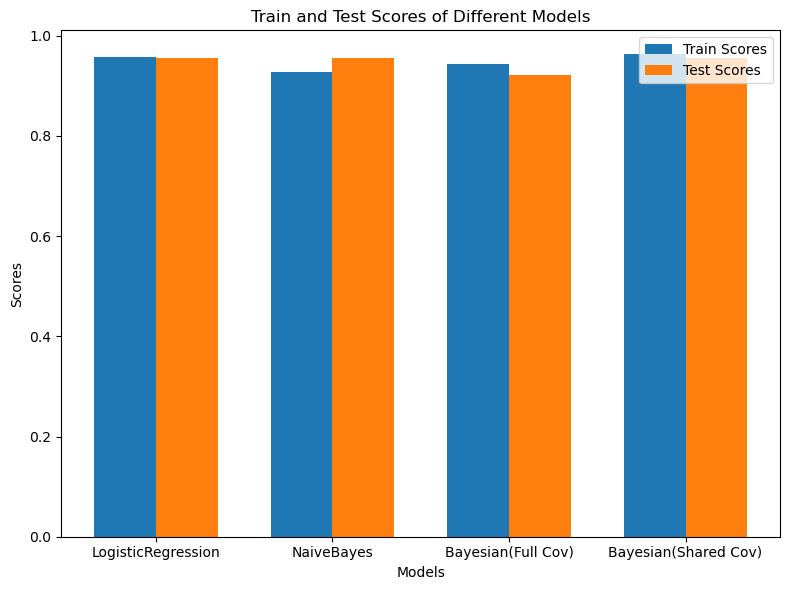

In [21]:
import matplotlib.pyplot as plt

# Combine train and test scores for each model
train_test_scores = np.array([train_scores, test_scores])

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.35
index = np.arange(len(model_names))

train_bars = ax.bar(index, train_test_scores[0], bar_width, label='Train Scores')
test_bars = ax.bar(index + bar_width, train_test_scores[1], bar_width, label='Test Scores')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Train and Test Scores of Different Models')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(model_names)
ax.legend()

plt.tight_layout()
plt.show()


### It seems like the logistic regression model generalizes better to unseen data compared to the Bayesian classifiers on this particular dataset.

## Question 7(Part-II)

## *  Experimenting for test the performance for increasing training sizes of N = 5, 10, . . . , 500.


In [26]:
# Define the range of training sizes
train_sizes = range(5, 501, 5)

# Initialize arrays to store train and test scores for each model
log_reg_train_scores = np.zeros((len(train_sizes), 10))
log_reg_test_scores = np.zeros((len(train_sizes), 10))
nb_train_scores = np.zeros((len(train_sizes), 10))
nb_test_scores = np.zeros((len(train_sizes), 10))
bc_full_cov_train_scores = np.zeros((len(train_sizes), 10))
bc_full_cov_test_scores = np.zeros((len(train_sizes), 10))
bc_shared_cov_train_scores = np.zeros((len(train_sizes), 10))
bc_shared_cov_test_scores = np.zeros((len(train_sizes), 10))


##  * For each N sample 10 training sets of the corresponding size, fit all models, and record training and test errors.

In [27]:
# Iterate over training sizes
for i, train_size in enumerate(train_sizes):
    for j in range(10):
        # Perform train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=j, shuffle=True)
        
        # Fit and evaluate models
        log_reg.fit(X_train, y_train)
        log_reg_train_scores[i, j] = log_reg.score(X_train, y_train)
        log_reg_test_scores[i, j] = log_reg.score(X_test, y_test)
        
        nb.fit(X_train, y_train)
        nb_train_scores[i, j] = accuracy_score(y_train, nb.predict(X_train))
        nb_test_scores[i, j] = accuracy_score(y_test, nb.predict(X_test))
        
        bc_full_cov.fit(X_train, y_train)
        bc_full_cov_train_scores[i, j] = accuracy_score(y_train, bc_full_cov.predict(X_train))
        bc_full_cov_test_scores[i, j] = accuracy_score(y_test, bc_full_cov.predict(X_test))
        
        bc_shared_cov.fit(X_train, y_train)
        bc_shared_cov_train_scores[i, j] = accuracy_score(y_train, bc_shared_cov.predict(X_train))
        bc_shared_cov_test_scores[i, j] = accuracy_score(y_test, bc_shared_cov.predict(X_test))

## Question 7(Part-III)

## Create suitable plots that compare the mean train and test performances of all models as a function of training size.

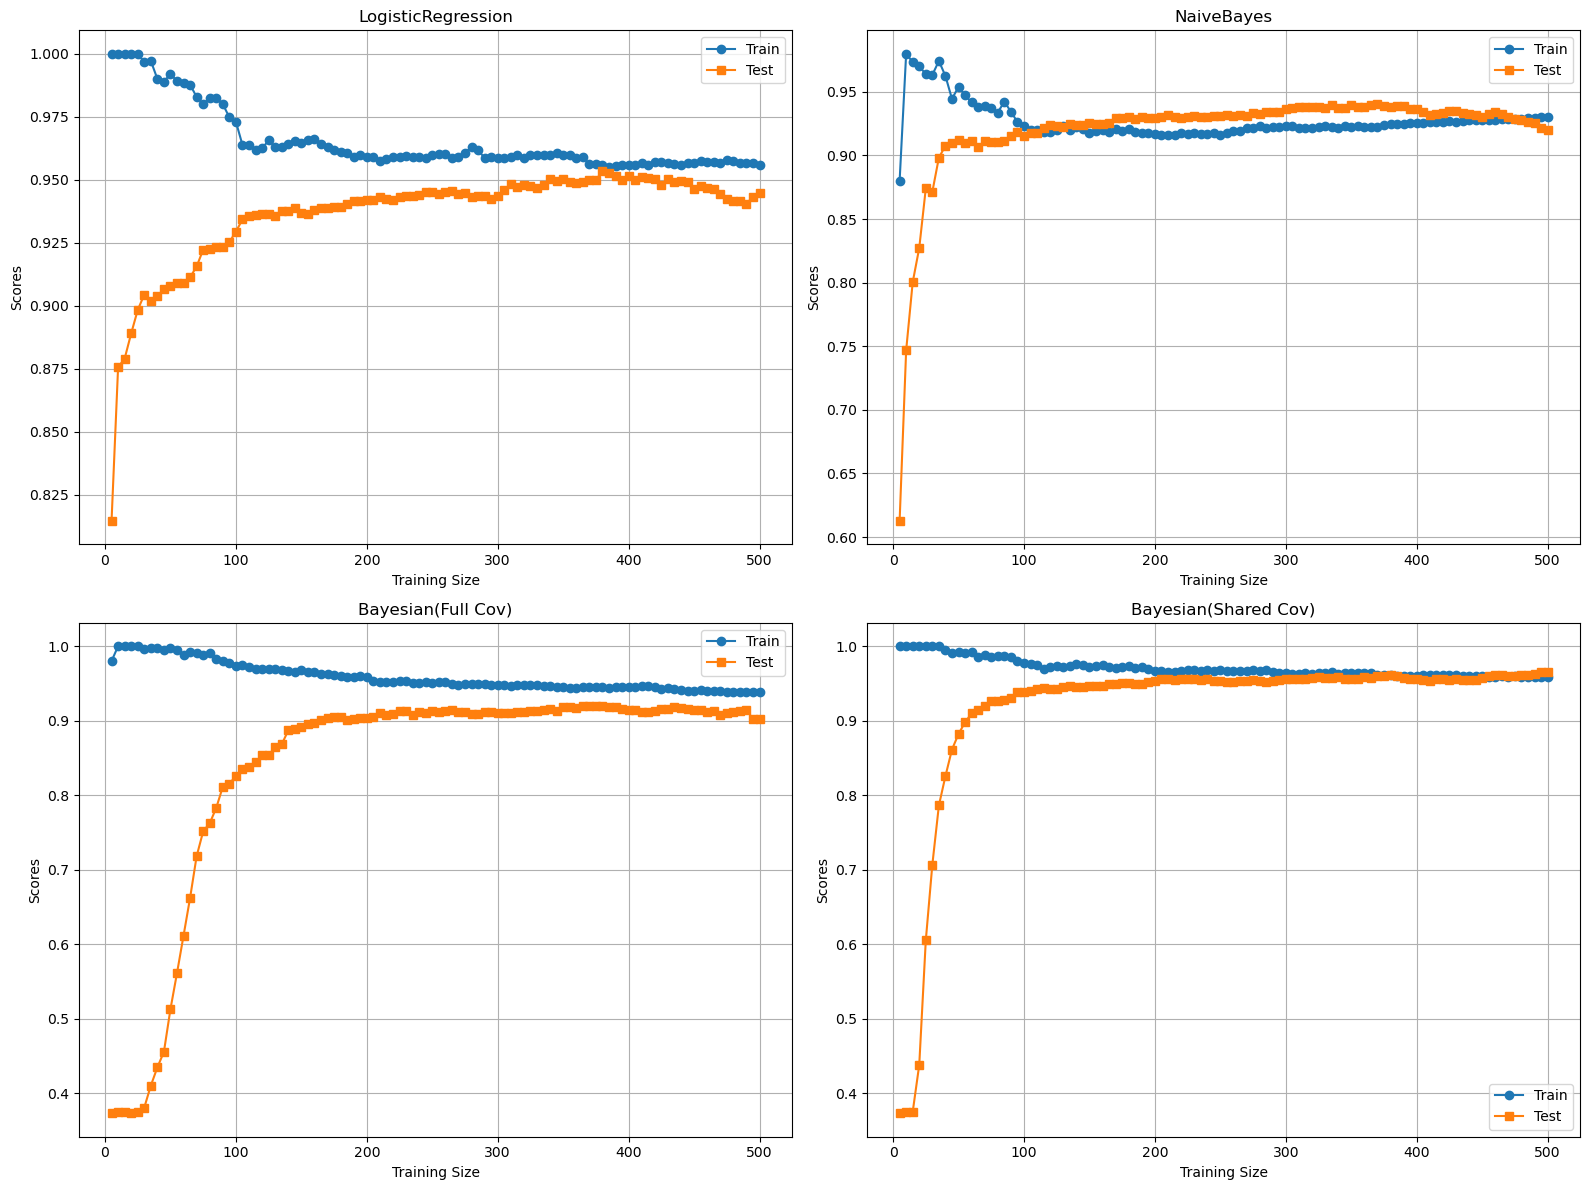

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Compute mean train and test scores for each model
log_reg_mean_train_scores = np.mean(log_reg_train_scores, axis=1)
log_reg_mean_test_scores = np.mean(log_reg_test_scores, axis=1)

nb_mean_train_scores = np.mean(nb_train_scores, axis=1)
nb_mean_test_scores = np.mean(nb_test_scores, axis=1)

bc_full_cov_mean_train_scores = np.mean(bc_full_cov_train_scores, axis=1)
bc_full_cov_mean_test_scores = np.mean(bc_full_cov_test_scores, axis=1)

bc_shared_cov_mean_train_scores = np.mean(bc_shared_cov_train_scores, axis=1)
bc_shared_cov_mean_test_scores = np.mean(bc_shared_cov_test_scores, axis=1)

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.flatten()

# Plot LogisticRegression
axs[0].plot(train_sizes, log_reg_mean_train_scores, marker='o', label='Train')
axs[0].plot(train_sizes, log_reg_mean_test_scores, marker='s', label='Test')
axs[0].set_xlabel('Training Size')
axs[0].set_ylabel('Scores')
axs[0].set_title('LogisticRegression')
axs[0].legend()
axs[0].grid(True)

# Plot NaiveBayes
axs[1].plot(train_sizes, nb_mean_train_scores, marker='o', label='Train')
axs[1].plot(train_sizes, nb_mean_test_scores, marker='s', label='Test')
axs[1].set_xlabel('Training Size')
axs[1].set_ylabel('Scores')
axs[1].set_title('NaiveBayes')
axs[1].legend()
axs[1].grid(True)

# Plot Bayesian(Full Cov)
axs[2].plot(train_sizes, bc_full_cov_mean_train_scores, marker='o', label='Train')
axs[2].plot(train_sizes, bc_full_cov_mean_test_scores, marker='s', label='Test')
axs[2].set_xlabel('Training Size')
axs[2].set_ylabel('Scores')
axs[2].set_title('Bayesian(Full Cov)')
axs[2].legend()
axs[2].grid(True)

# Plot Bayesian(Shared Cov)
axs[3].plot(train_sizes, bc_shared_cov_mean_train_scores, marker='o', label='Train')
axs[3].plot(train_sizes, bc_shared_cov_mean_test_scores, marker='s', label='Test')
axs[3].set_xlabel('Training Size')
axs[3].set_ylabel('Scores')
axs[3].set_title('Bayesian(Shared Cov)')
axs[3].legend()
axs[3].grid(True)

plt.tight_layout()
plt.show()


## Question 7(Part-IV)
## Formulate answers to the following questions:


##  What happens to each classifiers train and test performance when the number of training data points is increased?

* The training performance of all classifiers may slightly decrease when the number of training data points is increased. Because it becomes more challenging for the models to perfectly fit the training data as the dataset size grows. With more data, the models might find it harder to capture every detail of the training set.

* However, the test performance of all classifiers tends to improve.Because as the models are trained on more data, they become exposed to a greater variety of examples during training which help models  to generalize better to unseen data, resulting in improved performance on the test set. 

## b Which classifier is best suited when the training set is small, and which is best suited when the training set is big?

* When the training set is small, the Naive Bayes classifier tends to perform relatively well compared to the other classifiers. This is because Naive Bayes makes strong independence assumptions and requires fewer training examples to estimate its parameters.This suggests that Naive Bayes is best suited when limited training data is available, as it can still achieve decent performance.
* As the training set size increases, the logistic regression model and the Bayesian classifier with shared covariance tend to outperform the Naive Bayes classifier. These models are more expressive and can capture more complex relationships in the data when provided with sufficient training examples.

## c Justify your observations by providing some speculations and possible reasons.

* Naive Bayes for Small Training Sets:
  * Simple Model: Naive Bayes makes strong assumptions about the independence of features, which simplifies the model. With a small training set, having a simpler model can prevent overfitting and perform reasonably well.
  *  Less Data Required: Since Naive Bayes assumes independence between features, it requires fewer data points to estimate its parameters accurately. so it's easier to estimate parameters with limited data.
  * Lower Risk of Overfitting: Complex models may overfit when trained on small datasets by capturing noise instead of true patterns. Naive Bayes tends to be less prone to overfitting in such scenarios.

* Logistic Regression and Bayesian Classifier with Shared Covariance for Large Training Sets:
    * Expressive Models:These are more expressive models that can capture complex relationships and patterns in the data. With a large training set, these models have more opportunities to learn and represent these intricate relationships effectively.
  * Reduced Bias: More data provide better coverage of the underlying distribution, allowing more accurate estimation of model parameters.Which reduced the risk of bias.
  * Also , Complex models tend to generalize better with more data. which leads to improved performance on unseen data.

#### References-
Tutorial-
* Activity 3.1 and  3.2 -Implementing the Bayes Classifier 
* https://learning.monash.edu/mod/folder/view.php?id=2062935
* https://en.wikipedia.org/wiki/Naive_Bayes_classifier

